In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

import astropy.units as u
from astropy.coordinates import EarthLocation, AltAz
# from astropy.coordinates import SkyCoord
# from astropy.coordinates import solar_system_ephemeris
from astropy.coordinates import get_sun
from astropy.time import Time

In [2]:
# Coordinates of UTR-2 radio telescope
longitude = '36d56m27.560s'
latitude = '+49d38m10.310s'
elevation = 156 * u.m
observatory = 'UTR-2, Ukraine'
utr2_location = EarthLocation.from_geodetic(longitude, latitude, elevation)

# start_time = Time('2024-02-01 05:00:00')
# end_time = Time('2024-02-01 20:02:00')

start_time = Time('2020-06-04 12:20:00')
end_time = Time('2020-06-04 12:30:00')

n_points = 50  # Number of points to calculate within the time window

 As the example we have solar burst on  2020.06.04  at  12:26:40 UTC   (15:26:40 UTC+3)
 
 GURT beam code according to UV-log at this time: 
``` python
UTC+3: 4/6/2020 15:26:15.004 U= A V= 4  #C9C5
```
Which corresponds to codes: U = 01010 (0Ah, x = +6), V = 00100 (04h, y = +4), No 47 in PLT designation

In [21]:
## GURT parameters reading from file
file = open('DATA/GURT_parameters/AmaxGOST(f)_f=8,80,1.txt', 'r')

# First line - directions number
first_line = file.readline()
first_line = first_line.split()

directions = []
for i in range(1, len(first_line)):
    directions.append(int(first_line[i])-1)
no_of_directions = len(directions)

# Skip blank line
_ = file.readline()

# Read data by freqency
freq_num = 73
a_eff_gost = np.zeros((no_of_directions, freq_num), dtype=float)
frequency = np.zeros((freq_num), dtype=float)

for i in range(freq_num):
    line = file.readline()
    line = line.split()
    frequency[i] = float(line[0])
    for j in range(1, no_of_directions+1):
        a_eff_gost[j-1, i] = float(line[j])

Text(0, 0.5, 'Aeff, m2')

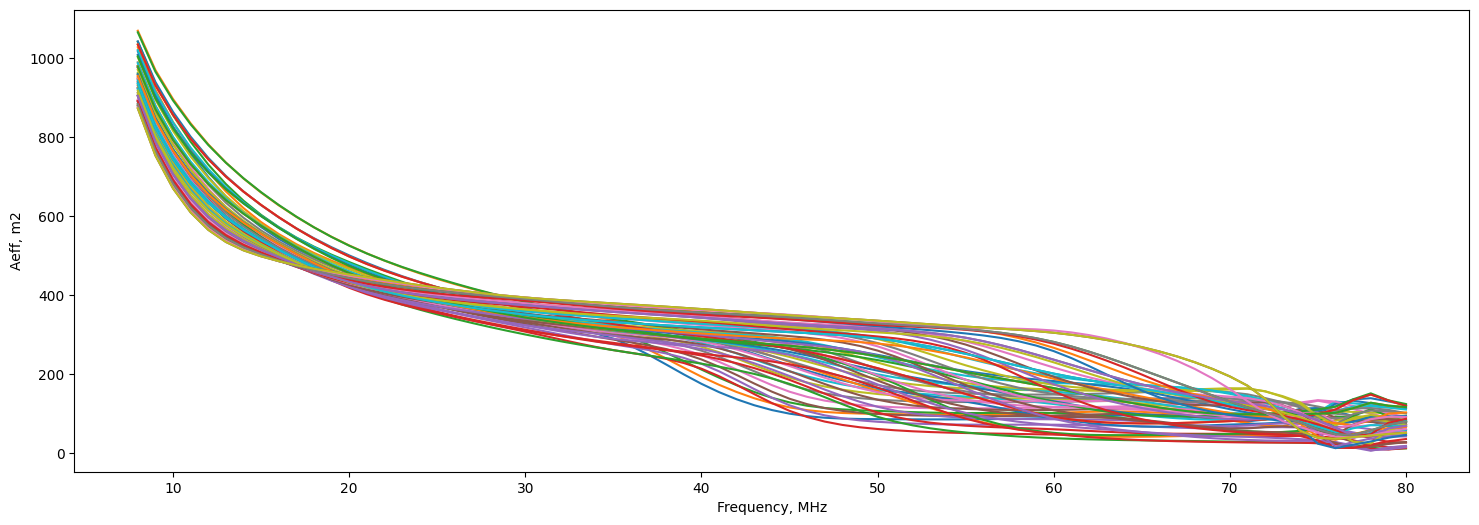

In [4]:
fig, ax0 = plt.subplots(1, 1, figsize=(18, 6)) 
for i in range(no_of_directions):
    ax0.plot(frequency[:], a_eff_gost[i, :])
ax0.set_xlabel('Frequency, MHz')
ax0.set_ylabel('Aeff, m2')

(-0.5, 1892.5, 1775.5, -0.5)

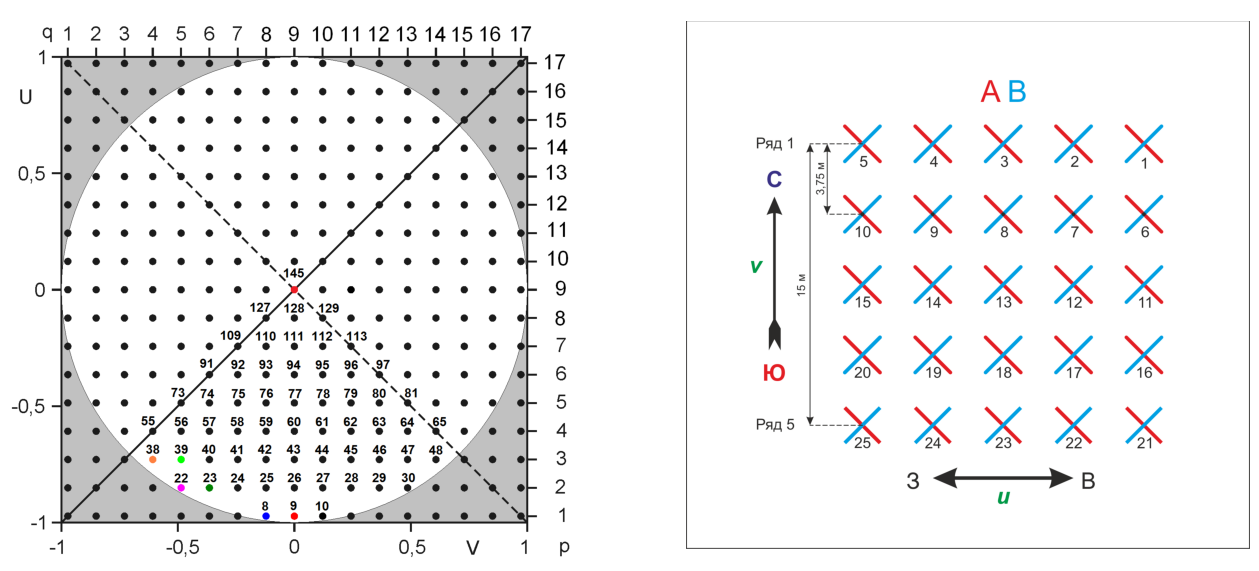

In [5]:
img_0 = mpimg.imread('DATA/GURT_parameters/1_UV_1-289.png')
img_1 = mpimg.imread('DATA/GURT_parameters/GURT_polarization.png')

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8))
ax0.imshow(img_0)
ax0.axis('off')
ax1.imshow(img_1)
ax1.axis('off')

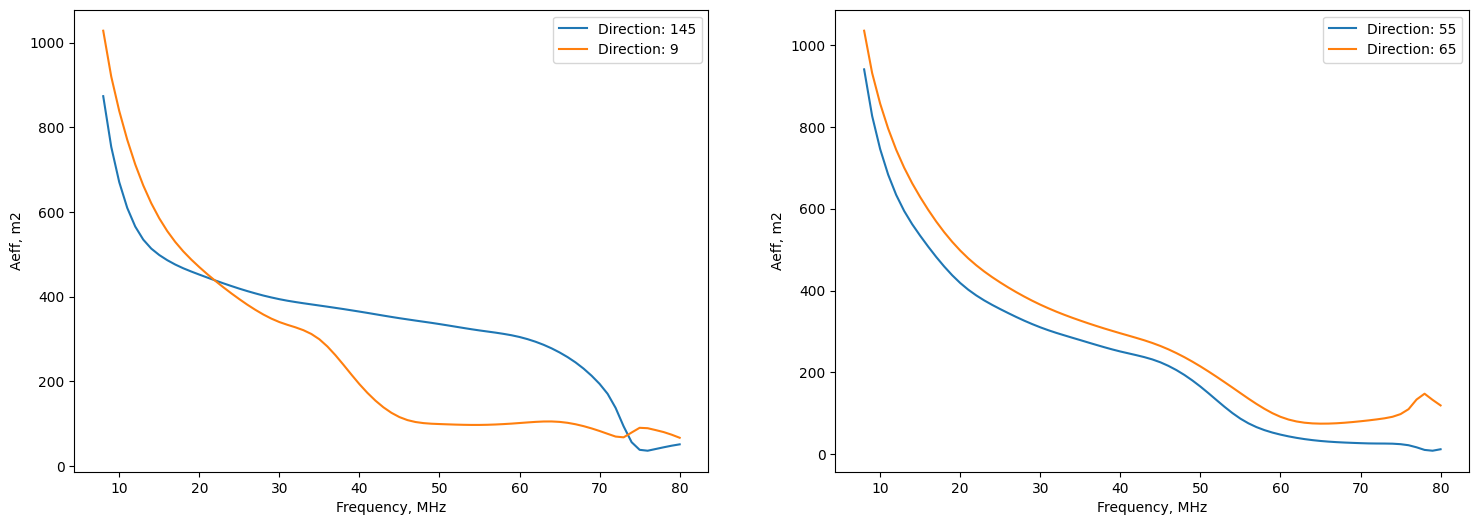

In [6]:
dir_0 = 145
dir_1 = 9
dir_2 = 55
dir_3 = 65

ind_0 = directions.index(dir_0-1)
ind_1 = directions.index(dir_1-1)
ind_2 = directions.index(dir_2-1)
ind_3 = directions.index(dir_3-1)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18,6)) 
ax0.plot(frequency[:], a_eff_gost[ind_0, :], label=('Direction: ' + str(dir_0)))
ax0.plot(frequency[:], a_eff_gost[ind_1, :], label=('Direction: ' + str(dir_1)))
ax0.set_xlabel('Frequency, MHz')
ax0.set_ylabel('Aeff, m2')
ax0.legend()
ax1.plot(frequency[:], a_eff_gost[ind_2, :], label=('Direction: ' + str(dir_2)))
ax1.plot(frequency[:], a_eff_gost[ind_3, :], label=('Direction: ' + str(dir_3)))
ax1.set_xlabel('Frequency, MHz')
ax1.set_ylabel('Aeff, m2')
ax1.legend()

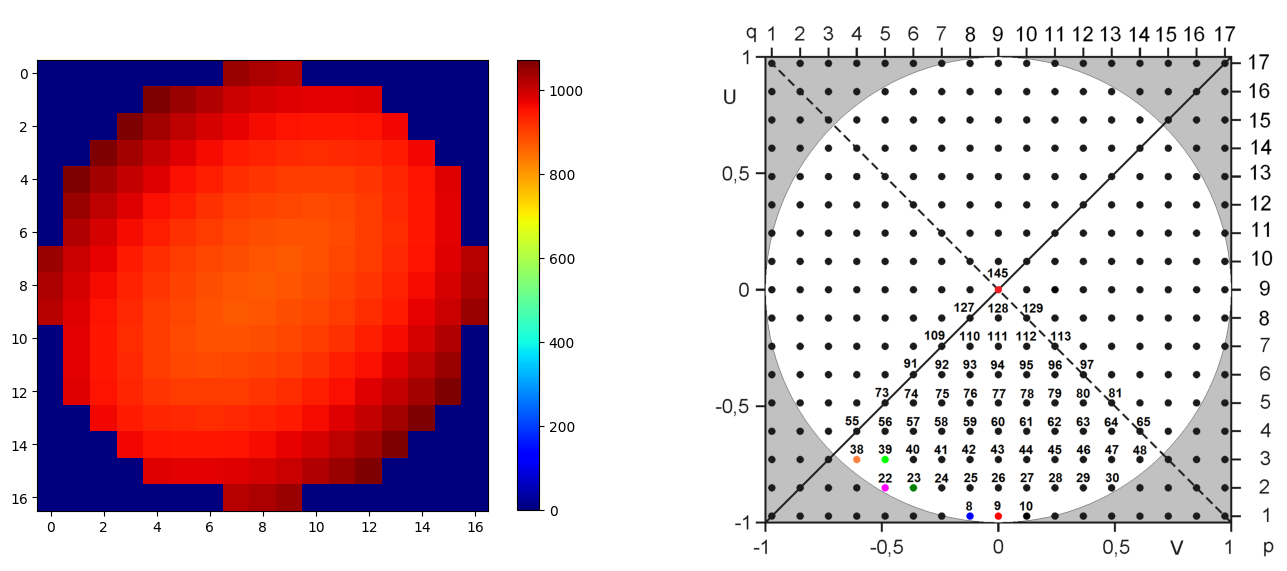

In [7]:
uv_dir_no = 17
a_eff_gost_sq = np.zeros((uv_dir_no, uv_dir_no, freq_num), dtype=float)

for f in range(freq_num):
    temp = np.zeros(uv_dir_no * uv_dir_no, dtype=float) 
    for i in range(len(directions)):
        temp[directions[i]] = a_eff_gost[i, f]

    temp = np.reshape(temp, [17, 17])
    temp = np.flipud(temp) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#
    a_eff_gost_sq[:,:,f] = temp[:,:]

# Mirror up-down
a_eff_gost_sq[0:8:1, :, :] = a_eff_gost_sq[16:8:-1,:,:]
# Mirror left-right upper part
a_eff_gost_sq[0:8, 0:16:1, :] = a_eff_gost_sq[0:8, 16:0:-1, :]

# Now we rotate the copy of the points, flip it from left to right, make diagonal elements zero and add to the initial array
rot_a_eff = np.rot90(a_eff_gost_sq.copy())
rot_a_eff = np.fliplr(rot_a_eff)
for i in range(uv_dir_no):
    rot_a_eff[i, i] = 0
    rot_a_eff[uv_dir_no-1-i, i] = 0
a_eff_gost_sq = a_eff_gost_sq + rot_a_eff

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8))
pos = ax0.imshow(a_eff_gost_sq[:,:,0], cmap='jet')
ax1.imshow(img_0)
ax1.axis('off')
fig.colorbar(pos, ax=ax0, shrink=0.73);

In [8]:
time_window = start_time + (end_time - start_time) * np.linspace(0, 1, n_points)
frame = AltAz(obstime=time_window, location=utr2_location)

# Coordinates of Sun
sun_alt_az = get_sun(time_window).transform_to(frame)

Text(0.682, 0.875, '2020-06-04 12:30:00 UTC')

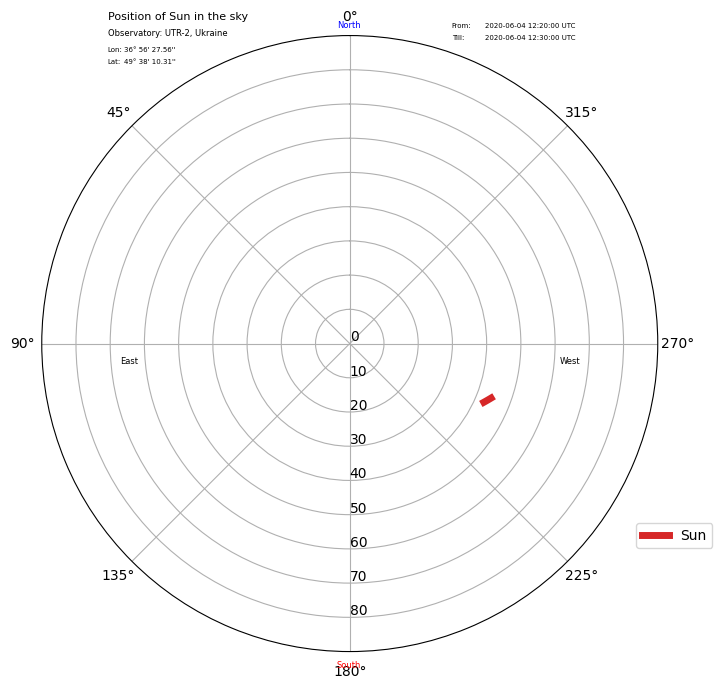

In [9]:
# Preparing data for correct sky plot (Altitude / Azimuth) Sun
r_sun = np.zeros(len(sun_alt_az))
r_sun[:] = sun_alt_az[:].alt.degree
r_sun[r_sun < 0] = 0
r_sun[:] = (90 - r_sun[:])
r_sun[r_sun > 89] = np.inf

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111, projection='polar')
ax1.set_theta_zero_location("N")
ax1.plot(sun_alt_az.az.rad, r_sun, label='Sun', color='C3', linewidth=5, alpha=1.0)
ax1.set_ylim(0, 90)
ax1.set_yticks(np.arange(0, 90, 10))
ax1.set_rlabel_position(180)
plt.legend(loc='upper right', bbox_to_anchor=(1.10, 0.22))
fig.text(0.497, 0.890, 'North', fontsize=6, color='b', transform=plt.gcf().transFigure)
fig.text(0.225, 0.470, 'East', fontsize=6, transform=plt.gcf().transFigure)
fig.text(0.775, 0.470, 'West', fontsize=6, transform=plt.gcf().transFigure)
fig.text(0.496, 0.090, 'South', fontsize=6, color='r', transform=plt.gcf().transFigure)
fig.text(0.210, 0.900, 'Position of Sun in the sky', fontsize=8, transform=plt.gcf().transFigure)
fig.text(0.210, 0.880, 'Observatory: ' + observatory, fontsize=6, transform=plt.gcf().transFigure)
fig.text(0.210, 0.860, 'Lon:', fontsize=5, transform=plt.gcf().transFigure)
fig.text(0.210, 0.845, 'Lat:', fontsize=5, transform=plt.gcf().transFigure)
fig.text(0.230, 0.860, str(utr2_location.lon).replace("d", "\u00b0 ").replace("m", "\' ").replace("s", "\'\' "),
             fontsize=5, transform=plt.gcf().transFigure)
fig.text(0.230, 0.845, str(utr2_location.lat).replace("d", "\u00b0 ").replace("m", "\' ").replace("s", "\'\' "),
             fontsize=5, transform=plt.gcf().transFigure)
fig.text(0.640, 0.890, 'From:', fontsize=5, transform=plt.gcf().transFigure)
fig.text(0.640, 0.875, 'Till:', fontsize=5, transform=plt.gcf().transFigure)
fig.text(0.682, 0.890, str(start_time)[0:19] + ' UTC', fontsize=5, transform=plt.gcf().transFigure)
fig.text(0.682, 0.875, str(end_time)[0:19] + ' UTC', fontsize=5, transform=plt.gcf().transFigure)

25
Direction # 125 , at  33.0 MHz , effective area =  367.8  sq. m.


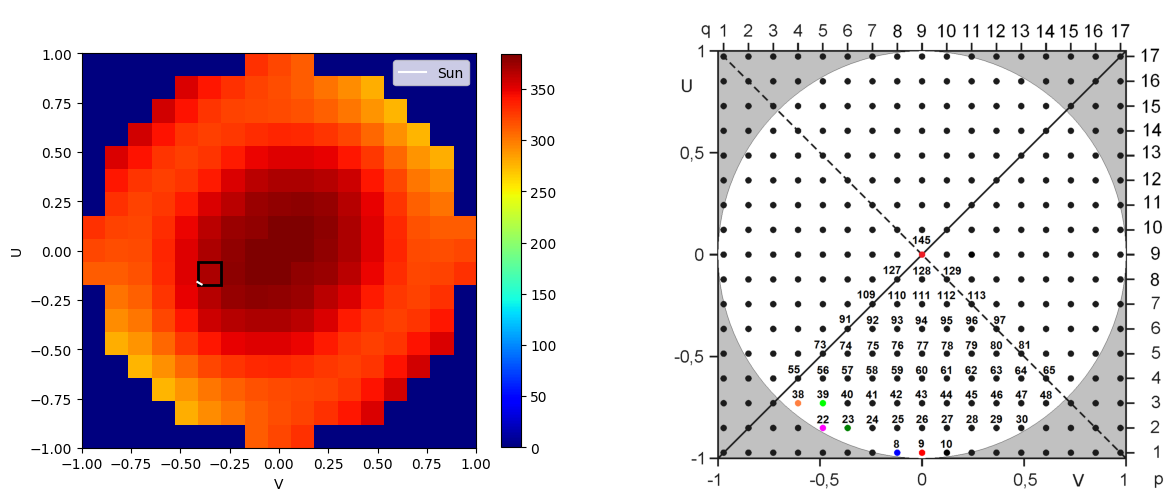

In [24]:
# Convert altitude - azimuth to uv code
cor_u = (r_sun / 100) * np.sin(sun_alt_az.az.rad)
cor_v = (r_sun / 100) * np.cos(sun_alt_az.az.rad)

# Create a Rectangle patch
p = 8      # As in figure
q = 6      # As in figure
freq = 33  # MHz

freq_ind, = np.where(np.isclose(frequency, freq))
freq_ind = freq_ind[0]
print(freq_ind)

start_x = -1 + (q-1) * 1/8.5
start_y = -1 + (p-1) * 1/8.5
l = 1/8.5

rect = patches.Rectangle((start_x, start_y), l, l, linewidth=2, edgecolor='black', facecolor='none')

pa = 17-p  # Index of Aeff
qa = q-1   # Index of Aeff
# a_eff_gost_sq[pa, qa, 0] = 1200  # Use only to indicate the square in the plot

cur_dir = 17 * (p-1) + q  # Current direction

print('Direction #', cur_dir, ', at ', frequency[freq_ind],'MHz , effective area = ', a_eff_gost_sq[pa, qa, freq_ind], ' sq. m.')

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 7)) 
pos = ax0.imshow(a_eff_gost_sq[:, :, freq_ind], cmap='jet', extent=[-1, 1, -1, 1])
ax0.add_patch(rect)
ax0.plot(cor_u, cor_v, label=('Sun'), color='white')
ax0.set_xlabel('V')
ax0.set_ylabel('U')
ax0.set_aspect('equal')
ax0.set_xlim([-1, 1])
ax0.set_ylim([-1, 1])
ax0.legend()
ax1.imshow(img_0)
ax1.axis('off')
fig.colorbar(pos, ax=ax0, shrink=0.73);

 Solar burst on  2020.06.04  at  12:26:40 UTC   (15:26:40 UTC+3)
 
 GURT beam code according to UV-log at this time: 
``` python
UTC+3: 4/6/2020 15:26:15.004 U= A V= 4  #C9C5
```
Which corresponds to codes: U = 01010 (0Ah, x = +6), V = 00100 (04h, y = +4), No 47 in PLT designation

In [14]:
filename = 'DATA/A200604_105919.adr_12-26-30 - 12-27-10.txt'
file = open(filename, 'r')
param = []
for line in file:
    num = line.rstrip().split()
    floatnum = [float(i) for i in num]
    param.append(floatnum)
file.close()
param = np.array((param))
print ('  Shape of the array: ', param.shape)

  Shape of the array:  (2048, 400)


In [15]:
f_min = 0.038                                                         # MHz
f_max = 78.125                                                        # MHz
n_channels = 2048
frequency = np.linspace(f_min, f_max, n_channels)                     # MHz
t_resolution = 0.1                                                    # Seconds
f_resolution = ((f_max - f_min) / n_channels) * 1000000
print(' Frequency resolution: ', f_resolution / 1000, ' kHz.')
print(' Frequency resolution: ', f_resolution, ' Hz.')
print('      Time resolution: ', t_resolution, ' s.')

 Frequency resolution:  38.12841796875  kHz.
 Frequency resolution:  38128.41796875  Hz.
      Time resolution:  0.1  s.


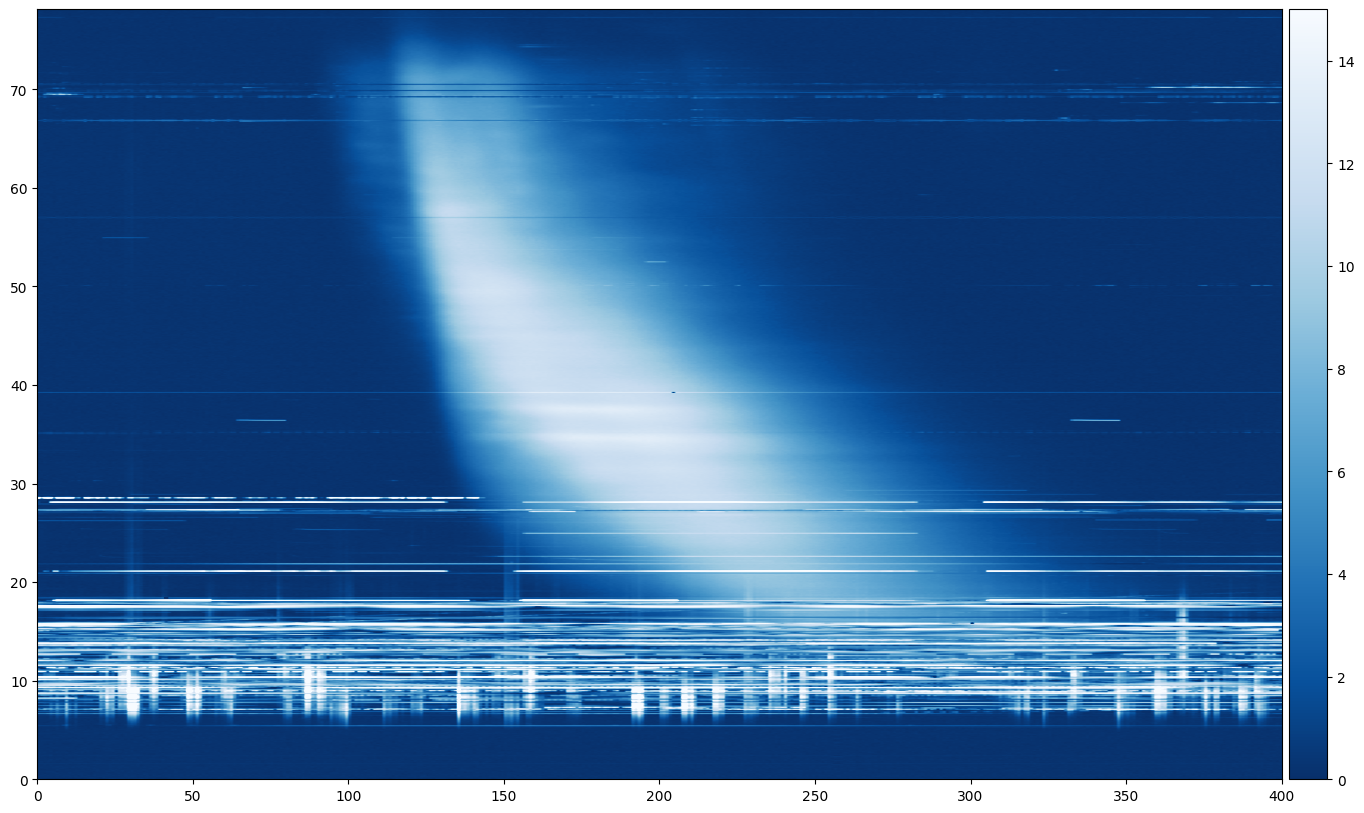

In [17]:
v_min = 0
v_max = 15
fig = plt.figure(figsize=(19.0, 10.0))
ax1 = fig.add_subplot(111)
im0 = ax1.imshow(np.flipud(param), aspect='auto', vmin=v_min, vmax=v_max, cmap='Blues_r', \
                  extent=[0, param.shape[1], 0, f_max])
cbar = fig.colorbar(im0, ax=ax1, pad=0.005)